In [1]:
from concurrent.futures import ThreadPoolExecutor
import os
import random
import numpy as np
import json
import tarfile
from tqdm import tqdm
import subprocess
import tensorflow_datasets as tfds
import cv2

from PIL import Image
from IPython import display

# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch
import matplotlib.pyplot as plt

def as_gif(images, path='temp.gif'):
  # Render the images as the gif:
  images[0].save(path, save_all=True, append_images=images[1:], duration=1000, loop=0)
  gif_bytes = open(path,'rb').read()
  return gif_bytes

def save_imgs(imgs, path):
  for i, img in enumerate(imgs):
    # save as 00000.jpg, 00001.jpg, ...
    img.save(f"{path}/{i:05d}.jpg")

In [2]:
data_root = f'/media/gvl/ACDA-BDB0/datasets/bridge/bridge_dataset/1.0.0'
b_tfds = tfds.builder_from_directory(builder_dir=data_root)

samples_all = {
    'train': {},
    'val': {}
}

for trainval in ['val', 'train']:
    ds = b_tfds.as_dataset(split=trainval)
    if not os.path.exists(f'demo/{trainval}'):
        os.makedirs(f'demo/{trainval}')
    for episode in tqdm(ds):
        images = [step['observation']['image_0'] for step in episode['steps']]
        new_width = 256
        new_height = 256
        resized_images = []

        for image in images:
            resized_image = Image.fromarray(image.numpy()).resize((new_width, new_height))
            resized_images.append(resized_image)
        save_imgs(resized_images, f'demo/{trainval}/')

        ee_traj_6d = [step['observation']['state'] for step in episode['steps']]
        ee_traj_6d = np.array(ee_traj_6d)
        np.save(f'ee_traj_6d.npy', ee_traj_6d)

        break
    break

2025-02-18 12:43:58.892870: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-18 12:43:58.900645: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739911438.909608 1005793 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739911438.912256 1005793 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-18 12:43:58.922101: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Try SAM2 here

In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [4]:
from sam2.build_sam import build_sam2_video_predictor
print(os.getcwd())
# sam2_checkpoint = "third_party/sam2/checkpoints/sam2.1_hiera_large.pt"
# model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
sam2_checkpoint = "third_party/sam2/checkpoints/sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

/home/gvl/Documents/Junjie/projects/ours/oxe_cam_calibration


In [5]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200, color='green'):
    unknown_points = coords[labels==-1]
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(unknown_points[:, 0], unknown_points[:, 1], color=color, marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

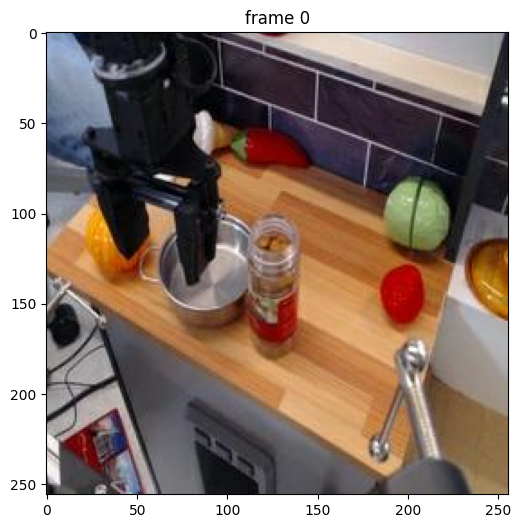

In [6]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "demo/val/"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [7]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG):   0%|          | 0/38 [00:00<?, ?it/s]

frame loading (JPEG): 100%|██████████| 38/38 [00:00<00:00, 88.48it/s]


In [8]:
predictor.reset_state(inference_state)

/home/gvl/Documents/Junjie/projects/ours/oxe_cam_calibration/third_party/sam2/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/home/gvl/Documents/Junjie/projects/ours/oxe_cam_calibration/third_party/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


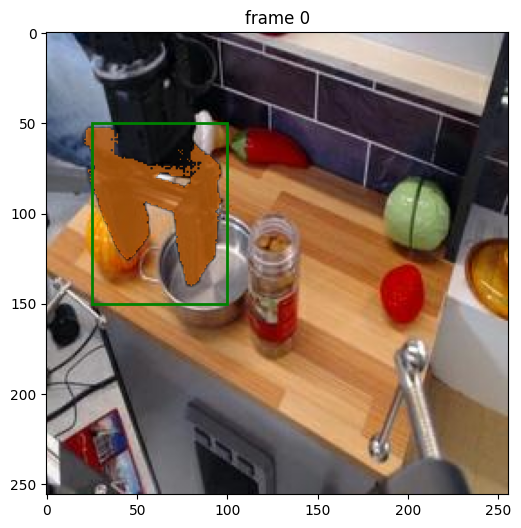

In [9]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a box at (x_min, y_min, x_max, y_max) = (300, 0, 500, 400) to get started
box = np.array([25, 50, 100, 150], dtype=np.float32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    box=box,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_box(box, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [19]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# # render the segmentation results every few frames
# vis_frame_stride = 1
# plt.close("all")
# video_frames = []
# for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
#     plt.figure(figsize=(6, 4))
#     plt.title(f"frame {out_frame_idx}")
#     plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
#     for out_obj_id, out_mask in video_segments[out_frame_idx].items():
#         show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

# Define the frame stride
vis_frame_stride = 1

# Define video parameters
output_video_path = "segmentation_results.mp4"
frame_width, frame_height = 256, 256  # Adjust based on your images
fps = 5  # Frames per second

# Initialize video writer
fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Codec for mp4
video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_title(f"Frame {out_frame_idx}")
    
    # Load and display the image
    img = Image.open(os.path.join(video_dir, frame_names[out_frame_idx]))
    ax.imshow(img)

    # Overlay segmentation masks
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, ax, obj_id=out_obj_id)
    
    # remove axis
    ax.axis("off")
    # tight
    plt.tight_layout()

    # Save the figure as an image
    fig.canvas.draw()
    img_array = np.array(fig.canvas.renderer.buffer_rgba())

    # Convert from RGBA to BGR for OpenCV
    img_bgr = cv2.cvtColor(img_array, cv2.COLOR_RGBA2BGR)
    img_resized = cv2.resize(img_bgr, (frame_width, frame_height))

    # Write frame to video
    video_writer.write(img_resized)

    # Close the figure to free memory
    plt.close(fig)

# Release the video writer
video_writer.release()
print(f"Video saved at {output_video_path}")

propagate in video: 100%|██████████| 38/38 [00:00<00:00, 74.10it/s]


Video saved at segmentation_results.mp4


In [11]:
def get_mask_center(binary_mask):
    """
    Compute the centroid of a binary mask.

    Parameters:
    binary_mask (numpy.ndarray): A 2D numpy array of shape (256, 256) containing 0s and 1s.

    Returns:
    tuple: (cx, cy) representing the centroid coordinates.
    """
    # Get the coordinates of nonzero (mask) pixels
    y_coords, x_coords = np.where(binary_mask > 0)

    if len(x_coords) == 0 or len(y_coords) == 0:
        return None  # No foreground pixels found

    # Compute centroid
    cx = int(np.mean(x_coords))
    cy = int(np.mean(y_coords))

    return cx, cy

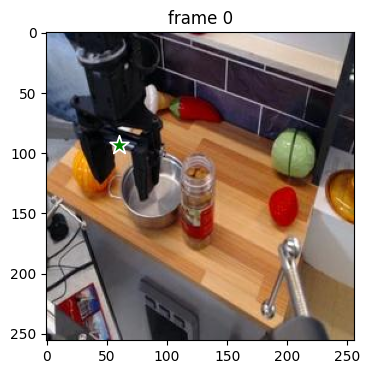

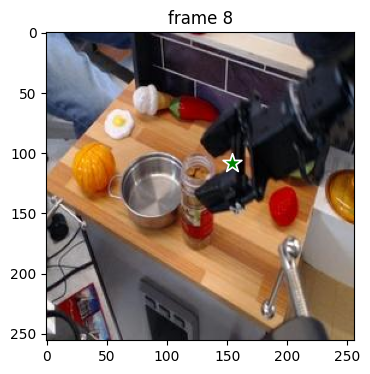

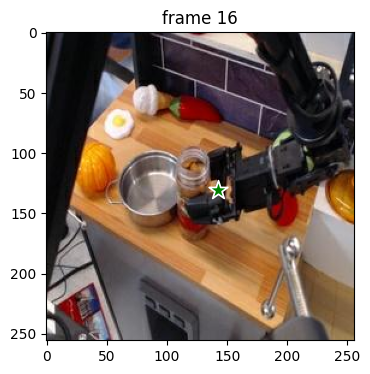

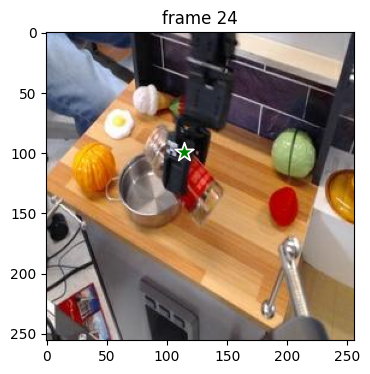

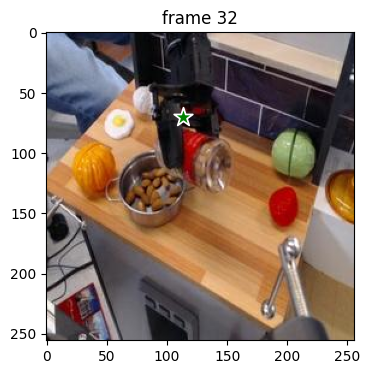

In [12]:
# render the segmentation results every few frames
ee_traj_2d = []

vis_frame_stride = 1
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    if out_frame_idx % 8 == 0:
        plt.figure(figsize=(6, 4))
        plt.title(f"frame {out_frame_idx}")
        plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        centre_pt = get_mask_center(out_mask[0])
        if out_frame_idx % 8 == 0:
            show_points(np.array([centre_pt]), np.array([1]), plt.gca())
        ee_traj_2d.append(centre_pt)

# save the 2D trajectory as a npy file
ee_traj_2d = np.array(ee_traj_2d)
np.save("ee_traj_2d.npy", ee_traj_2d)


## Estimate camera parameters from 2D-3D correspondences

In [ ]:
from data_preprocessing.correspondences2poses import estimate_camera_parameters, intrinsics_resize, proj_3d_to_2d, decompose_projection_matrix
import numpy as np
import matplotlib.pyplot as plt
import cv2

ee_traj_2d = np.load("ee_traj_2d.npy").astype(np.float32)
ee_traj_3d = np.load("ee_traj_6d.npy")[..., :3].astype(np.float32)

img_width, img_height = 256, 256

init_intrinsic=np.array(
                    [[623.588, 0, 319.501], 
                     [0, 623.588, 239.545], 
                     [0, 0, 1]], dtype=np.float32
                ) # logitech C920
init_intrinsic = intrinsics_resize(init_intrinsic, (640, 480), (img_width, img_height))

print(init_intrinsic)

[[249.43521   0.      127.80041]
 [  0.      332.5803  127.75734]
 [  0.        0.        1.     ]]


In [14]:
## assume known camera intrinsics
success, rvec, tvec = cv2.solvePnP(ee_traj_3d, ee_traj_2d, init_intrinsic, None, flags=cv2.SOLVEPNP_ITERATIVE)
# Convert rotation vector to matrix
Rot, _ = cv2.Rodrigues(rvec)

# Construct the 3x4 transformation matrix
P = np.hstack((Rot, tvec))
print(P)
reproj_2d, _ = cv2.projectPoints(ee_traj_3d, rvec, tvec, init_intrinsic, None)
reproj_2d = reproj_2d.squeeze()

projection_matrix = np.dot(init_intrinsic, P)
print(projection_matrix)

[[-0.51652944  0.85002283  0.10324009  0.13903444]
 [ 0.60892413  0.27987608  0.74221344 -0.17861945]
 [ 0.60200394  0.44624048 -0.66216365 -0.36337588]]
[[ -51.90428205  269.05533972  -58.87307011  -11.75950157]
 [ 279.42658514  150.09176389  162.2492964  -105.82924337]
 [   0.60200394    0.44624048   -0.66216365   -0.36337588]]


In [15]:
## assume unknown camera intrinsics
from sklearn.linear_model import RANSACRegressor

points_3d_pr = np.concatenate([ee_traj_3d, np.ones_like(ee_traj_3d[:, :1])], axis=-1)
points_2d_pr = np.concatenate([ee_traj_2d, np.ones_like(ee_traj_2d[:, :1])], axis=-1)
print(points_3d_pr.shape, points_2d_pr.shape)
reg = RANSACRegressor(random_state=0).fit(points_3d_pr, points_2d_pr)

# Extract coefficients and intercept
A = reg.estimator_.coef_  # Shape: (3, 4)
b = reg.estimator_.intercept_  # Shape: (3,)

# Construct the transformation matrix
transformation_matrix = np.hstack([A[:, :-1], b.reshape(-1, 1)])  # Shape: (3, 5)

print("Transformation matrix (3x4):\n", transformation_matrix)

pr_pos = reg.predict(points_3d_pr)[:, :-1].astype(int)

print(pr_pos)

# pr_pos_new = transformation_matrix @ points_3d_pr.T
# pr_pos_new = pr_pos_new[:2] / pr_pos_new[2]
# pr_pos_new = pr_pos_new.T.astype(int)

np.save("project_matrix.npy", transformation_matrix)

(38, 4) (38, 3)
Transformation matrix (3x4):
 [[ 344.02072 -807.53406 -153.75781   36.75052]
 [-625.48505 -368.41522 -780.04895  308.67163]
 [   0.         0.         0.         1.     ]]
[[ 58  90]
 [ 58  91]
 [ 61  98]
 [ 83 101]
 [ 90 103]
 [114  95]
 [130  94]
 [141  96]
 [151 107]
 [158 116]
 [160 111]
 [163 110]
 [158 116]
 [153 118]
 [150 121]
 [145 125]
 [139 129]
 [134 133]
 [131 136]
 [131 137]
 [130 128]
 [127 114]
 [122 112]
 [118 102]
 [114  96]
 [116  89]
 [115  86]
 [114  84]
 [116  89]
 [118  95]
 [118  90]
 [120  85]
 [119  85]
 [118  87]
 [119  85]
 [110  74]
 [ 83  38]
 [ 84  28]]


In [16]:
intrinsics, rot, trans = decompose_projection_matrix(transformation_matrix)

LinAlgError: Singular matrix

In [ ]:
# cam_mtx, dist, Rot, tvec = estimate_camera_parameters(
#     ee_traj_3d, ee_traj_2d, 
#     (img_width, img_height), 
#     coarse_intrinsics=init_intrinsic,
#     known_intrinsics=True,
#     estimate_distortion=False
# )

# print(f"Estimated camera matrix: {cam_mtx}")
# print(f"Estimated distortion coefficients: {dist}")
# print(f"Estimated rotation matrix: {Rot}")
# print(f"Estimated translation vector: {tvec}")

# # world_to_cam = np.zeros((3, 4))
# # world_to_cam[:3, :3] = cv2.Rodrigues(rvec)[0]
# # world_to_cam[:3, 3] = tvec.squeeze()

# # world_to_pix = np.matmul(cam_mtx, world_to_cam)

# # print(f"Estimated world-to-pixel matrix: {world_to_pix}")

Estimated camera matrix: [[249.43521   0.      127.80041]
 [  0.      332.5803  127.75734]
 [  0.        0.        1.     ]]
Estimated distortion coefficients: [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Estimated rotation matrix: [[-0.5134363   0.85331539  0.09075247]
 [ 0.59205136  0.27569644  0.75727582]
 [ 0.62117498  0.44254302 -0.64675909]]
Estimated translation vector: [[ 0.13962412]
 [-0.17546321]
 [-0.37229548]]


In [ ]:
# ## try with the parameters in simpler env

# from scipy.spatial.transform import Rotation as R
# q = [0.909182, -0.0819809, 0.347277, 0.214629]
# Rot = R.from_quat(q)
# Rot = Rot.as_matrix()

# tvec = np.array([0.00, -0.16, 0.336])

# cam_mtx=np.array(
#                     [[623.588, 0, 319.501], 
#                      [0, 623.588, 239.545], 
#                      [0, 0, 1]]
#                 ) # logitech C920

# ee_traj_3d = np.load("ee_traj_6d.npy")[..., :3]

# reproj_2d = proj_3d_to_2d(ee_traj_3d, Rot, tvec, cam_mtx)
# reproj_2d.shape


(38, 2)

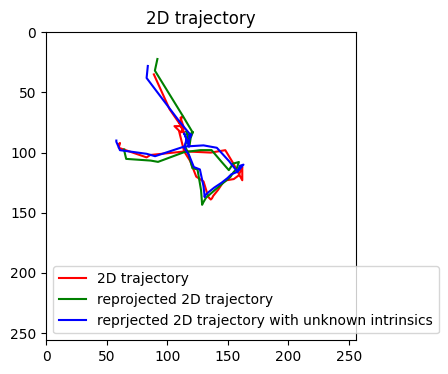

In [20]:
plt.figure(figsize=(4, 4))
plt.title("2D trajectory")
plt.plot(ee_traj_2d[:, 0], ee_traj_2d[:, 1], 'r', label='2D trajectory')
plt.plot(reproj_2d[:, 0], reproj_2d[:, 1], 'g', label='reprojected 2D trajectory')
plt.plot(pr_pos[:, 0], pr_pos[:, 1], 'b', label='reprjected 2D trajectory with unknown intrinsics')
plt.xlim(0, 256)
plt.ylim(256, 0)  # Reverse the vertical axis
plt.legend()
plt.show()

In [22]:
## plot on each frame
video_dir = "demo/val/"
vis_dir = video_dir.replace('val', 'eevis')
output_video_path = "output.mp4"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

os.makedirs(vis_dir, exist_ok=True)

vis_frame_stride = 1
plt.close("all")
frame_paths = []
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    if out_frame_idx % 1 == 0:
        plt.figure(figsize=(6, 4))
        plt.title(f"frame {out_frame_idx}")
        plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
        show_points(np.array([ee_traj_2d[out_frame_idx]]), np.array([-1]), plt.gca(), color='red')
        show_points(np.array([reproj_2d[out_frame_idx]]), np.array([-1]), plt.gca(), color='green')
        show_points(np.array([pr_pos[out_frame_idx]]), np.array([-1]), plt.gca(), color='blue')

        frame_path = os.path.join(vis_dir, f"frame_{out_frame_idx:04d}.png")
        plt.axis('off')  # Remove axis for cleaner visualization
        plt.savefig(frame_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        frame_paths.append(frame_path)

# Create video from frames
frame = cv2.imread(frame_paths[0])
height, width, _ = frame.shape
fps = 5  # Adjust frame rate as needed

fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 format
video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

for frame_path in frame_paths:
    img = cv2.imread(frame_path)
    video_writer.write(img)

video_writer.release()


: 